06-combine-two-mechanisms.ipynb
======================

In this section, we use the two tables from the previous sections to combine the two different mechanisms.

**Things to do**
* Test the results.

## Load packages and read tables.

In [1]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Read a summary table of the victimisation-based mechanism.
vic_tab = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/emp-net/vic_tab.parquet")
vic_tab.registerTempTable("vic_tab")

# Read a summary table of the observation-based mechanism.
obs_tab = spark.read.parquet("s3://jinny-capstone-data-test/summary-tables/emp-net/obs_tab.parquet")
obs_tab.registerTempTable("obs_tab")

In [4]:
# Show the first few rows of each dataset.
vic_tab.show()
obs_tab.show()

obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.e493e8036...|2019-03-02|2019-03-01|     1|        2|            0|           2|
|account.d30a1abaf...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.53db3bd71...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.47ff35eca...|2019-03-02|2019-03-01|     1|        1|            1|           1|
|account.52adde8ad...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.272b33c63...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.476ee023d...|2019-03-02|2019-03-01|     1|        1|            0|           1|
|account.d2cb5110d...|2019-03-03|2019-03-01|     2|        1|            0|           1|
|account.6825517dd...

## 1. Merge two tables.

In [5]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.090ca369b...|2019-03-02|
|account.272b33c63...|2019-03-02|
|account.da692c372...|2019-03-02|
|account.53db3bd71...|2019-03-02|
|account.ab15ceb31...|2019-03-02|
|account.8d69e3520...|2019-03-02|
|account.11dbd81ee...|2019-03-02|
|account.da1a6fa0b...|2019-03-02|
|account.27478c512...|2019-03-02|
|account.e493e8036...|2019-03-02|
+--------------------+----------+
only showing top 10 rows



In [6]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_obs IS NULL THEN 0 ELSE total_obs END AS total_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, 
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+---------+
|                  id|start_date|total_obs|total_exp|
+--------------------+----------+---------+---------+
|account.090ca369b...|2019-03-02|        3|        0|
|account.272b33c63...|2019-03-02|       11|        1|
|account.da692c372...|2019-03-02|        8|        0|
|account.53db3bd71...|2019-03-02|        1|        1|
|account.ab15ceb31...|2019-03-02|        1|        0|
|account.8d69e3520...|2019-03-02|       59|        0|
|account.11dbd81ee...|2019-03-02|        9|        0|
|account.da1a6fa0b...|2019-03-02|       35|        0|
|account.27478c512...|2019-03-02|       50|        0|
|account.e493e8036...|2019-03-02|       23|        2|
+--------------------+----------+---------+---------+
only showing top 10 rows



## 2. Get the number of times the motif appears in the network.

In [ ]:
# Find the number of cheaters who adopted cheating after being killed by cheating once and observing two cheaters.
merged_df.registerTempTable("merged_df")

motifs = spark.sql("SELECT * FROM merged_df WHERE total_exp = 1 AND total_obs = 2")
motifs.show()
print(motifs.count())

## 3. Plot the distribution of experiences and observations.

In [7]:
merged_tab = merged_df.toPandas()
merged_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
print(merged_tab)

    total_obs  total_exp  freq
0           1          0     3
1           1          1     1
2           2          0     2
3           2          1     1
4           3          0     8
5           3          1     1
6           4          0     2
7           6          0     4
8           7          0     1
9           8          0     3
10          8          3     1
11          9          0     1
12         10          1     1
13         11          1     2
14         12          1     1
15         13          0     1
16         14          0     1
17         15          0     1
18         16          0     1
19         17          0     1


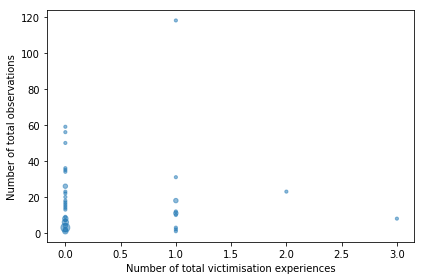

In [9]:
# Create a scatter plot.
fig = plt.scatter(merged_tab['total_exp'], merged_tab['total_obs'], s=merged_tab['freq']*10, alpha=0.5)
plt.title('')
plt.xlabel('Number of total victimisation experiences')
plt.ylabel('Number of total observations')
plt.tight_layout()
plt.show()